<a href="https://colab.research.google.com/github/mehular0ra/Pytorch-Tutorial/blob/main/PyTorch_Autoregressive_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Auto means 'self'. Autoregressive model means it trains on its own dataset only. This is a type of time-series prediction. 

The dimention of the model is as follows: N x T x D

Where:

N = number of data points;
T = Time series length;
D = Dimensions

In [167]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

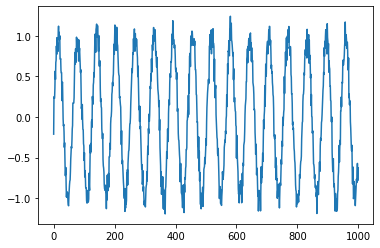

In [168]:
# make own data

# this data is without noise
N = 1000
series = np.sin(0.1*np.arange(N)) + + np.random.randn(N)*0.1

# plot it
plt.plot(series)
plt.show()

In [169]:
# build the dataset
# lets see if we can use past T datapoints to predict the next value
T = 10
X = []
Y = []

for t in range(len(series) - T):
    x = series[t: t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

In [170]:
X = np.array(X)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print(f"Total data points: {N}")

Total data points: 990


In [171]:
print(X.shape)
print(Y.shape)

(990, 10)
(990, 1)


In [172]:
# create a model
model = nn.Linear(T, 1)

In [173]:
# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [174]:
# make inputs and outputs
# first part of the series should training, second part should be prediction
X_train = torch.from_numpy(X[:N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:N//2].astype(np.float32))

X_test = torch.from_numpy(X[N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[N//2:].astype(np.float32))

In [175]:
print(y_train.shape)

torch.Size([495, 1])


In [176]:
# Training
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, n_epoch=200):
    # stuff the losses here
    train_losses = np.zeros(n_epoch)
    test_losses = np.zeros(n_epoch)

    for it in range(n_epoch):
        # zero the gradient parameters
        optimizer.zero_grad()

        # forward
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # backward 
        loss.backward()
        optimizer.step()

        # save losses
        train_losses[it] = loss.item()

        # test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()

        if (it+1) % 5 == 0:
            print(f"Epoch: {it+1}/{n_epoch}, Train loss: {loss.item():.4f}, Test loss: {test_loss.item():.4f}")
        
    return train_losses, test_losses


In [177]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, 100)

Epoch: 5/100, Train loss: 0.1435, Test loss: 0.0593
Epoch: 10/100, Train loss: 0.0640, Test loss: 0.0233
Epoch: 15/100, Train loss: 0.0633, Test loss: 0.0376
Epoch: 20/100, Train loss: 0.0587, Test loss: 0.0438
Epoch: 25/100, Train loss: 0.0404, Test loss: 0.0346
Epoch: 30/100, Train loss: 0.0264, Test loss: 0.0265
Epoch: 35/100, Train loss: 0.0221, Test loss: 0.0236
Epoch: 40/100, Train loss: 0.0202, Test loss: 0.0216
Epoch: 45/100, Train loss: 0.0179, Test loss: 0.0185
Epoch: 50/100, Train loss: 0.0167, Test loss: 0.0173
Epoch: 55/100, Train loss: 0.0165, Test loss: 0.0166
Epoch: 60/100, Train loss: 0.0160, Test loss: 0.0160
Epoch: 65/100, Train loss: 0.0155, Test loss: 0.0154
Epoch: 70/100, Train loss: 0.0152, Test loss: 0.0152
Epoch: 75/100, Train loss: 0.0150, Test loss: 0.0150
Epoch: 80/100, Train loss: 0.0148, Test loss: 0.0149
Epoch: 85/100, Train loss: 0.0146, Test loss: 0.0148
Epoch: 90/100, Train loss: 0.0145, Test loss: 0.0147
Epoch: 95/100, Train loss: 0.0144, Test loss: 0

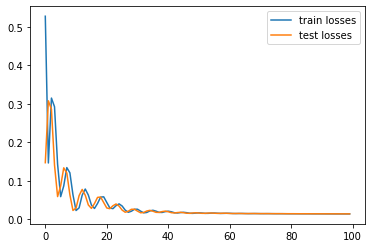

In [178]:
plt.plot(train_losses, label='train losses')
plt.plot(test_losses, label='test losses')
plt.legend()
plt.show()

In [179]:
# to check the shape of X_test
X_test.shape

torch.Size([495, 10])

In [180]:
# 'Wrong' forcast using true targets

validation_targets = Y[-N//2:]
validation_predictions = []

# # index for validation input
# i = 0

# while len(validation_predictions) < len(validation_targets):
#     input_ = X_test[i].reshape(1, -1)

validation_prediction = model(X_test)

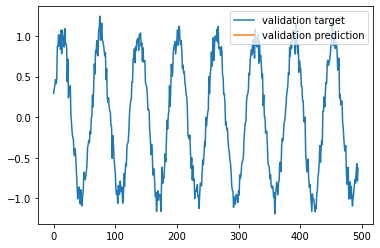

In [181]:
# 'Wrong' forcast using true targets

plt.plot(validation_targets, label='validation target')
plt.plot(validation_predictions, label='validation prediction')
plt.legend()
plt.show()

In [182]:
# 'Right' way of doing this (for self-predictions to make future predictions)

validation_targets = Y[-N//2:]
validation_predictions = []

# last_x = torch.from_numpy(X_test[-N//2].astype(np.float32))
last_x = X_test[-N//2]

while len(validation_predictions) < len(validation_targets):
    input_ = last_x.reshape(1, -1)
    p = model(input_)

    # store the prediction at this time step at validation_predictions
    validation_predictions.append(p[0, 0].item())

    # make new input
    last_x = torch.cat((last_x[1:], p[0]))


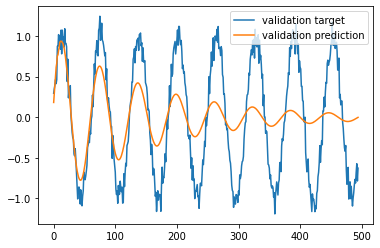

In [183]:
# 'Correct' forcast using self-prediction targets

plt.plot(validation_targets, label='validation target')
plt.plot(validation_predictions, label='validation prediction')
plt.legend()
plt.show()

## New Noice data

Try this with noisy data now, by addding + np.random.randn(N)*0.1